In [383]:
import osmnx as ox
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
from math import radians, cos, sin, asin, sqrt


import warnings
warnings.filterwarnings('ignore')

graph_filepath = "../data/iowa.graphml"
towns_cleaned_filepath = "../data/towns_cleaned.pkl"
states_shp_filepath = "../data/ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp"
states_map = gpd.read_file(states_shp_filepath)
iowa_map = states_map[states_map.name == 'Iowa']

past_routes = pd.read_csv('../data/past_routes.csv', index_col=0)
route_columns = ['Start', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'End']

with open(towns_cleaned_filepath, "rb") as f:
    towns = pickle.load(f)

## Count Occurances
Look at the number of occurances each town has for a given day

In [384]:
occurrences = {col: {} for col in route_columns}

def count_occurrences(value, col):
    if value in occurrences[col]:
        occurrences[col][value] += 1
    else:
        occurrences[col][value] = 1
    return occurrences[col][value]

for col in route_columns:
    past_routes[col + ' Occurrences'] = past_routes[col].apply(lambda x: count_occurrences(x, col))

past_routes

,route_id,Year,#,Miles,Feet of Climb,Riders,Start,Sunday,Monday,Tuesday,...,Friday,End,Start Occurrences,Sunday Occurrences,Monday Occurrences,Tuesday Occurrences,Wednesday Occurrences,Thursday Occurrences,Friday Occurrences,End Occurrences
0,0,1973,I,412,"12,637",130,Sioux City,Storm Lake,Fort Dodge,Ames,...,Davenport,NaN,1,1,1,1,1,1,1,1
1,1,1974,II,422,"12,648","2,000",Council Bluffs,Atlantic,Guthrie Center,Johnston,...,Monticello,Dubuque,1,1,1,1,1,1,1,1
2,2,1975,III,450,"12,573","3,000",Hawarden,Cherokee,Lake View,Boone,...,Mount Pleasant,Fort Madison,1,1,1,1,1,1,1,1
3,3,1976,IV,430,"13,737","4,000",Sidney,Red Oak,Harlan,Jefferson,...,Iowa City,Muscatine,1,1,1,1,1,1,1,1
4,4,1977,V,400,"8,479","6,000",Onawa,Ida Grove,Laurens,Algona,...,Decorah,Lansing,1,1,1,1,1,1,1,1
5,5,1978,VI,440,"11,238","6,000",Sioux City,Storm Lake,Humboldt,Iowa Falls,...,Maquoketa,Clinton,2,2,1,1,1,1,1,1
6,6,1979,VII,480,"11,836","6,000",Rock Rapids,Spencer,Rockwell City,Story City,...,Wapello,Burlington,1,1,1,1,1,1,1,1
7,7,1980,VIII,468,"11,912","6,000",Glenwood,Atlantic,Carroll,Perry,...,Elkader,Guttenberg,1,2,1,1,1,1,1,1
8,8,1981,IX,490,"14,372","6,000",Missouri Valley,Mapleton,Lake City,Greenfield,...,Keosauqua,Keokuk,1,1,1,1,1,1,1,1
9,9,1982,X,523,"10,935","6,000",Akron,Cherokee,Estherville,Forest City,...,Tipton,Davenport,1,2,1,1,1,1,1,1


In [385]:
past_routes[route_columns].head()

,Start,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,End
0,Sioux City,Storm Lake,Fort Dodge,Ames,Des Moines,Williamsburg,Davenport,NaN
1,Council Bluffs,Atlantic,Guthrie Center,Johnston,Marshalltown,Waterloo,Monticello,Dubuque
2,Hawarden,Cherokee,Lake View,Boone,Newton,Sigourney,Mount Pleasant,Fort Madison
3,Sidney,Red Oak,Harlan,Jefferson,Nevada,Grinnell,Iowa City,Muscatine
4,Onawa,Ida Grove,Laurens,Algona,Clear Lake,New Hampton,Decorah,Lansing


In [386]:
def print_first_occurance_stats(n_years):
    for col in route_columns:
        recent_years = past_routes[col + ' Occurrences'].iloc[-n_years:].to_numpy()
        first_counts = len(recent_years[recent_years == 1])
        print(f'{first_counts} of the last {n_years} years have been first occurances on {col}')

print_first_occurance_stats(n_years=10)
print()
print_first_occurance_stats(n_years=15)

2 of the last 10 years have been first occurances on Start
2 of the last 10 years have been first occurances on Sunday
1 of the last 10 years have been first occurances on Monday
4 of the last 10 years have been first occurances on Tuesday
2 of the last 10 years have been first occurances on Wednesday
3 of the last 10 years have been first occurances on Thursday
4 of the last 10 years have been first occurances on Friday
0 of the last 10 years have been first occurances on End

2 of the last 15 years have been first occurances on Start
2 of the last 15 years have been first occurances on Sunday
2 of the last 15 years have been first occurances on Monday
6 of the last 15 years have been first occurances on Tuesday
3 of the last 15 years have been first occurances on Wednesday
3 of the last 15 years have been first occurances on Thursday
4 of the last 15 years have been first occurances on Friday
0 of the last 15 years have been first occurances on End


In [387]:
# Number of unique cities per day
for col in route_columns:
    print(past_routes[col].nunique(), col)

14 Start
16 Sunday
23 Monday
29 Tuesday
29 Wednesday
29 Thursday
22 Friday
12 End


One possible starting town: Sioux Center	8,543   Northern Iowa

In [388]:
current_year = past_routes['Year'].max()

def calculate_years_since_visited(town):
    year_last_visited = past_routes[past_routes['Start'] == town].iloc[-1]['Year']
    return current_year - year_last_visited

start_frequency = past_routes['Start'].value_counts().reset_index()
start_frequency['years_since_visited'] = start_frequency['Start'].apply(calculate_years_since_visited)
start_frequency

,Start,count,years_since_visited
0,Sioux City,8,1
1,Glenwood,8,0
2,Council Bluffs,7,5
3,Onawa,6,6
4,Missouri Valley,4,16
5,Sioux Center,4,12
6,Hawarden,3,26
7,Rock Rapids,3,17
8,Le Mars,2,3
9,Sergeant Bluff,2,2


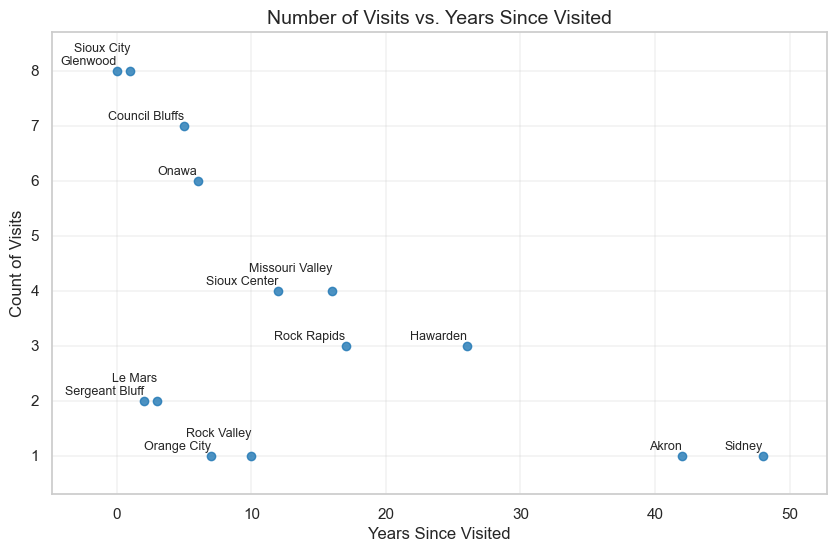

In [389]:
plt.figure(figsize=(10, 6))
plt.scatter(start_frequency['years_since_visited'], start_frequency['count'], alpha=0.8, color='tab:blue')

# Calculate limits to add padding 
x_min, x_max = start_frequency['years_since_visited'].min(), start_frequency['years_since_visited'].max()
y_min, y_max = start_frequency['count'].min(), start_frequency['count'].max()
x_padding = (x_max - x_min) * 0.1
y_padding = (y_max - y_min) * 0.1
plt.xlim(x_min - x_padding, x_max + x_padding)
plt.ylim(y_min - y_padding, y_max + y_padding)

for i, town in enumerate(start_frequency['Start']):
    y_buffer = 0.1 if town not in ['Missouri Valley', 'Rock Valley', 'Le Mars', 'Sioux City'] else 0.35
    plt.text(start_frequency['years_since_visited'][i], start_frequency['count'][i]+y_buffer, town, fontsize=9, ha='right')

plt.title('Number of Visits vs. Years Since Visited', fontsize=14)
plt.xlabel('Years Since Visited')
plt.ylabel('Count of Visits')
plt.grid(True, linewidth=.3)
plt.show()

In [390]:
def calculate_years_since_visited(town):
    year_last_visited = past_routes[past_routes['End'] == town].iloc[-1]['Year']
    return current_year - year_last_visited

end_frequency = past_routes['End'].value_counts().reset_index()
end_frequency['years_since_visited'] = end_frequency['End'].apply(calculate_years_since_visited)
end_frequency

,End,count,years_since_visited
0,Muscatine,6,8
1,Clinton,6,3
2,Burlington,6,0
3,Fort Madison,5,11
4,Guttenberg,5,10
5,Davenport,5,1
6,Bellevue,5,17
7,Dubuque,4,14
8,Lansing,3,2
9,Keokuk,3,5


In [492]:
start_towns = start_frequency.merge(towns, how='left', left_on='Start', right_on='name')
end_towns = end_frequency.merge(towns, how='left', left_on='End', right_on='name')

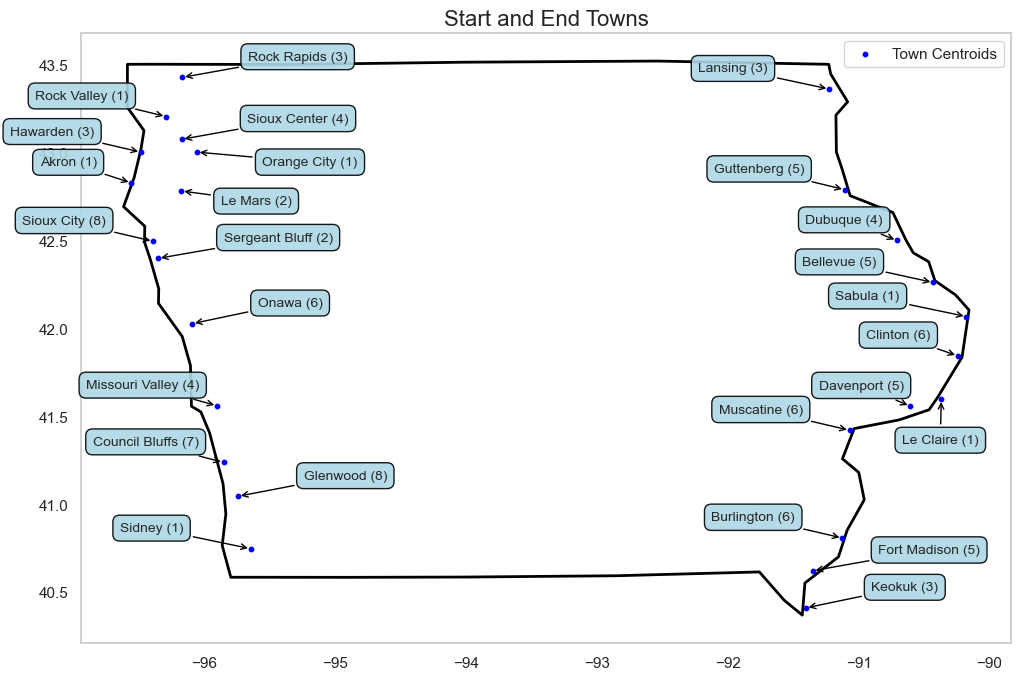

In [534]:
start_towns_gdf = gpd.GeoDataFrame(start_towns, geometry=start_towns.geometry)
end_towns_gdf = gpd.GeoDataFrame(end_towns, geometry=end_towns.geometry)

fig, ax = plt.subplots(figsize=(12, 8))
iowa_map.plot(ax=ax, color='none', edgecolor='black', linewidth=2, label='Iowa State Border')
start_towns_gdf['centroid'].plot(ax=ax, color='blue', marker='o', markersize=10, label='Town Centroids')
end_towns_gdf['centroid'].plot(ax=ax, color='blue', marker='o', markersize=10)

i = 0
for x, y, label, count in zip(start_towns_gdf['centroid'].x, start_towns_gdf['centroid'].y, start_towns_gdf['name'], start_towns_gdf['count']):
    i += 1

    if i%2 == 0:
        x_offset = 0.5
        if label in ['Akron']:
            x_offset = -0.7
    else:
        x_offset = -1
        if label in ['Le Mars']:
            x_offset = 0.3

    if label in ['Orange City', 'Le Mars']:
        y_offset = -0.75
    else: 
        y_offset = 1

    # Add label with arrow pointing to the centroid
    ax.annotate(
        text=str(label) + ' (' + str(count) + ')',
        xy=(x, y),  # Centroid coordinates
        xytext=(x + x_offset, y + 0.1 * y_offset),  # Offset for the label
        fontsize=10,
        bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.9),
        arrowprops=dict(color='black', arrowstyle='->', lw=1)
    )

i = 0
for x, y, label, count in zip(end_towns_gdf['centroid'].x, end_towns_gdf['centroid'].y, end_towns_gdf['name'], end_towns_gdf['count']):
    i += 1

    if i%2 == 0:
        x_offset = 0.5
        if label in ['Dubuque', 'Clinton', 'Davenport']:
            x_offset = -0.7
    else:
        x_offset = -1
        if label in ['Le Mars']:
            x_offset = 0.3

    y_offset = 1

    if label == 'Le Claire':
        x_offset = -0.3
        y_offset = -2.5


    # Add label with arrow pointing to the centroid
    ax.annotate(
        text=str(label) + ' (' + str(count) + ')',
        xy=(x, y),  # Centroid coordinates
        xytext=(x + x_offset, y + 0.1 * y_offset),  # Offset for the label
        fontsize=10,
        bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.9),
        arrowprops=dict(color='black', arrowstyle='->', lw=1)
    )

plt.title("Start and End Towns", fontsize=16)
plt.grid(False)
plt.legend()
plt.show()

## Years Since Last Traveled
Starting / Ending towns are typically revisited every 8-9 years. Wednesday / Thursday have the most variation

Median = 8.0


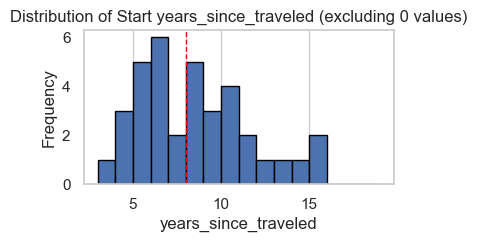

Median = 10.0


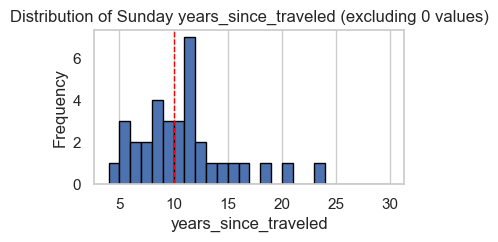

Median = 11.0


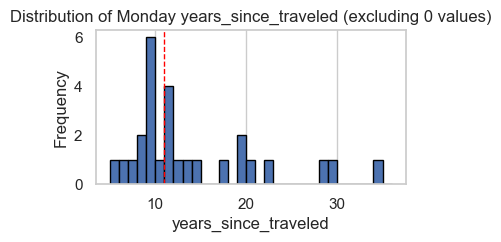

Median = 11.5


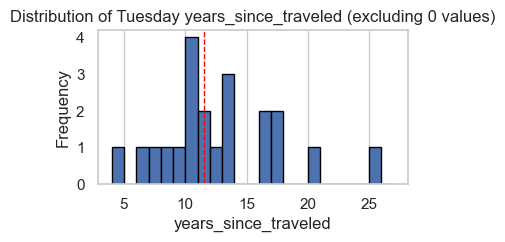

Median = 12.0


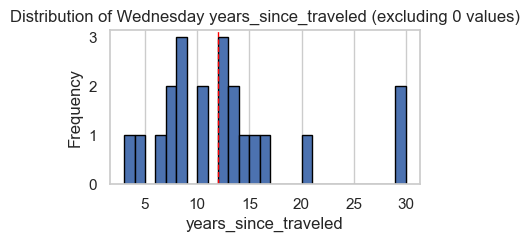

Median = 11.5


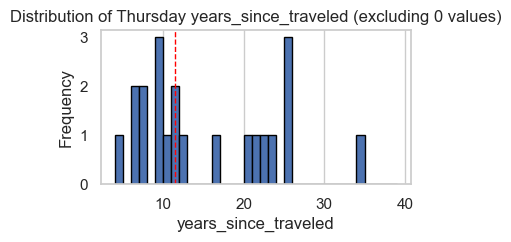

Median = 10.0


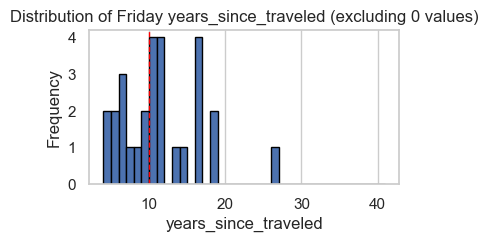

Median = 9.0


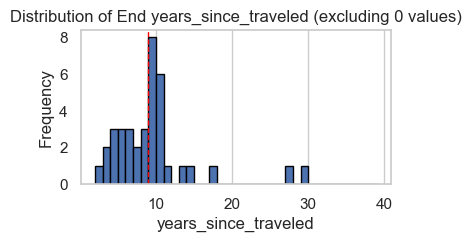

In [391]:
last_seen = {col: {} for col in route_columns}

def calculate_years_since_traveled(row, col):
    value = row[col]
    current_index = row.name
    if value in last_seen[col]:
        years = current_index - last_seen[col][value]
    else:
        years = 0
    last_seen[col][value] = current_index
    return years

# Apply the function to each specified column
for col in route_columns:
    past_routes[col + ' years_since_traveled'] = past_routes.apply(calculate_years_since_traveled, col=col, axis=1)


for col in route_columns:
    distance_col = col + ' years_since_traveled'
    non_zero_distances = past_routes[past_routes[distance_col] != 0][distance_col]
    plt.figure(figsize=(4, 2))
    # plt.hist(non_zero_distances, bins=range(1, non_zero_distances.max() + 2), edgecolor='black')
    plt.hist(non_zero_distances, bins=range(non_zero_distances.min(), non_zero_distances.max()), edgecolor='black')
    median_distance = non_zero_distances.median()
    plt.axvline(median_distance, color='red', linestyle='dashed', linewidth=1)
    print(f"Median = {median_distance}")
    # plt.text(median_distance, plt.ylim()[1] * 0.9, f'Median: {median_distance}', color='red', ha='center')
    plt.title(f'Distribution of {distance_col} (excluding 0 values)')
    plt.xlabel('years_since_traveled')
    plt.ylabel('Frequency')
    plt.grid(axis='y')
    plt.show()

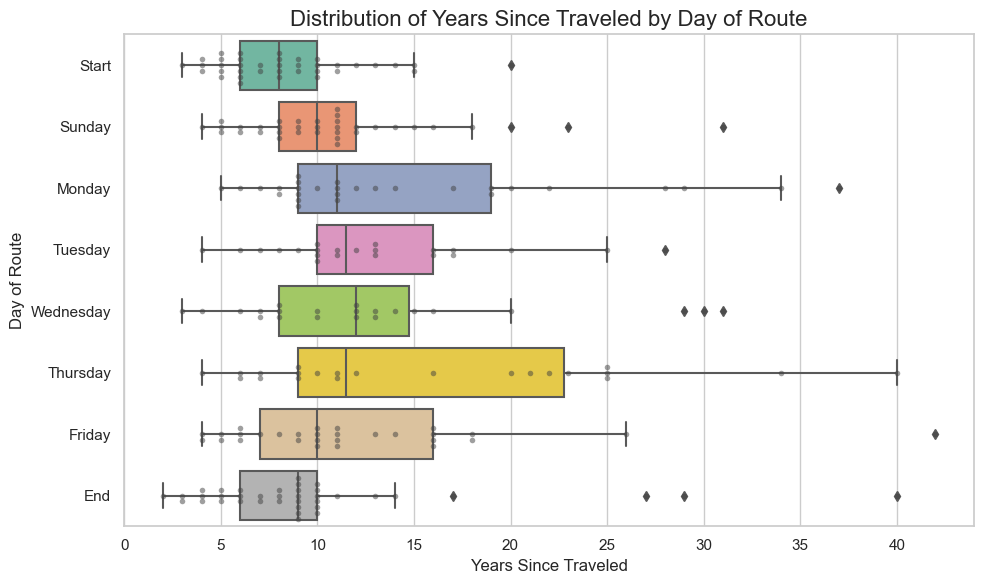

In [392]:
renamed_df = past_routes.rename(columns={'Start years_since_traveled': 'Start years_since_traveled', 
                                         'End years_since_traveled': 'End years_since_traveled'})
days = [
    'Start',
    'Sunday',
    'Monday',
    'Tuesday',
    'Wednesday',
    'Thursday',
    'Friday',
    'End'
]

# Melt the DataFrame to long format
melted_df = renamed_df.melt(
    id_vars=[],
    value_vars=[col + ' years_since_traveled' for col in days],
    var_name='Day',
    value_name='Years_Since_Traveled'
)
melted_df['Day'] = melted_df['Day'].str.replace(' years_since_traveled', '')
melted_df = melted_df[melted_df['Years_Since_Traveled'] != 0]
melted_df = melted_df.dropna(subset=['Years_Since_Traveled'])
melted_df['Years_Since_Traveled'] = melted_df['Years_Since_Traveled'].astype(int)

plt.figure(figsize=(10, 6))
sns.boxplot(
    x='Years_Since_Traveled',
    y='Day',
    data=melted_df,
    palette='Set2',
    orient='h'
)
sns.swarmplot(
    x='Years_Since_Traveled',
    y='Day',
    data=melted_df,
    color='0.25',
    alpha=0.5,
    size=4
)

# Add titles and labels
plt.title('Distribution of Years Since Traveled by Day of Route', fontsize=16)
plt.xlabel('Years Since Traveled')
plt.ylabel('Day of Route')
plt.tight_layout()
plt.show()

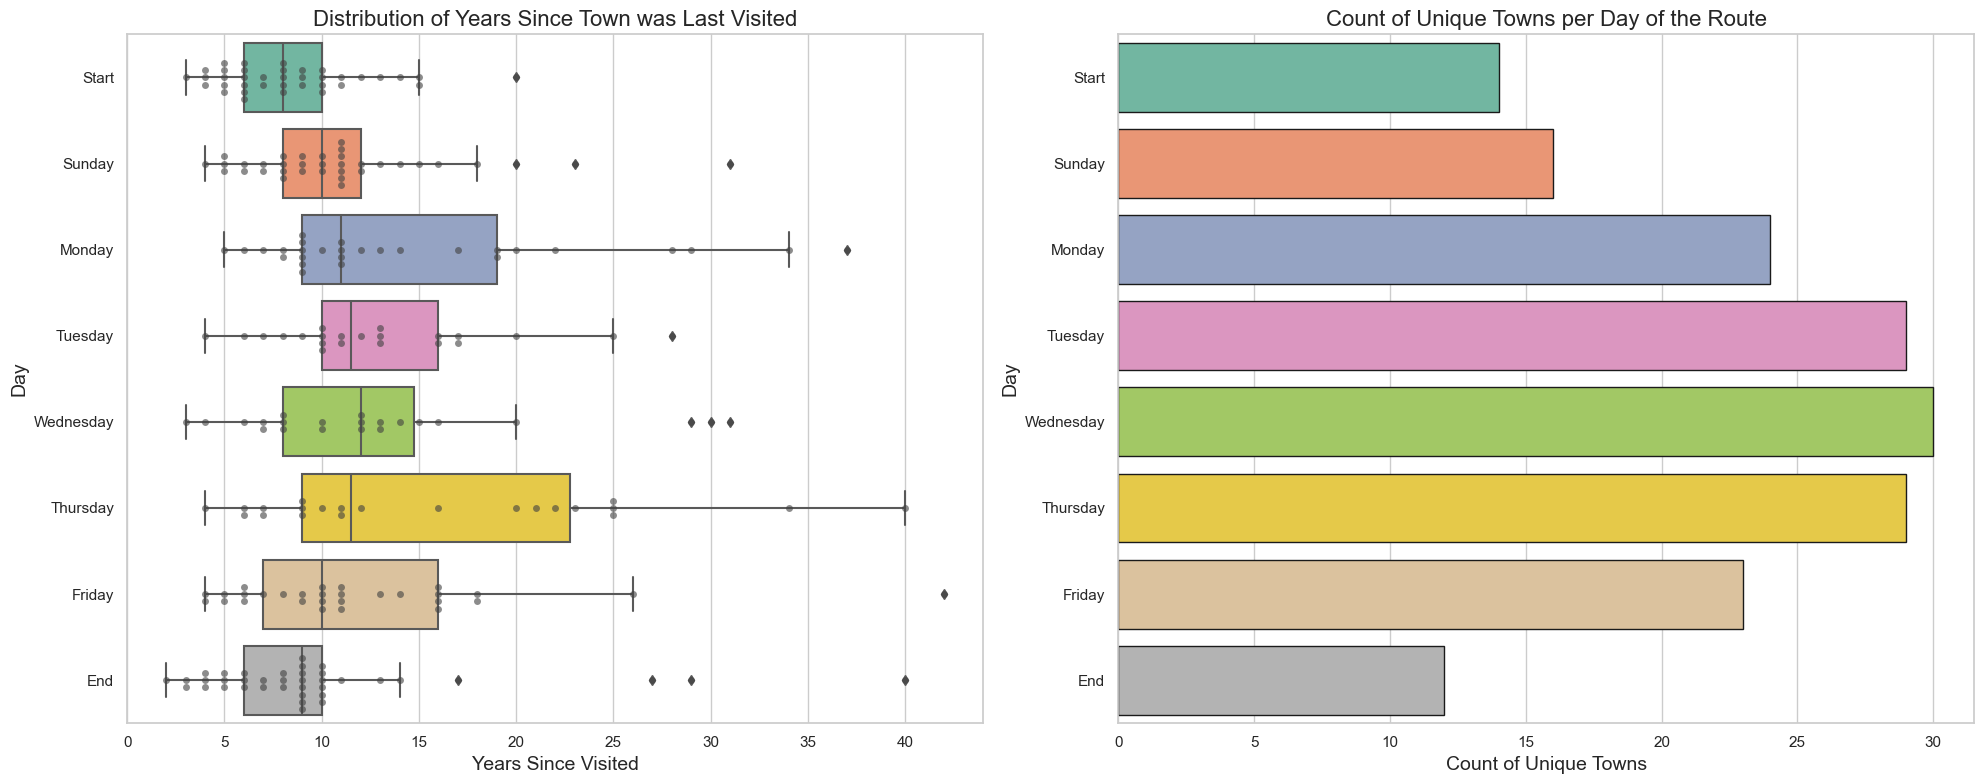

In [393]:
palette = 'Set2'
fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # Adjust figsize as needed

# --------------------
# First Plot
# --------------------
sns.boxplot(
    x='Years_Since_Traveled',
    y='Day',
    data=melted_df,
    palette=palette,
    orient='h',
    ax=axes[0]
)
sns.swarmplot(
    x='Years_Since_Traveled',
    y='Day',
    data=melted_df,
    color='0.25',
    alpha=0.6,
    size=5,
    ax=axes[0]
)
axes[0].set_title('Distribution of Years Since Town was Last Visited', fontsize=16)
axes[0].set_xlabel('Years Since Visited', fontsize=14)
axes[0].set_ylabel('Day', fontsize=14)

# --------------------
# Second Plot
# --------------------
unique_towns_df = pd.DataFrame({
    "Day": route_columns,
    "Unique Cities": [14, 16, 24, 29, 30, 29, 23, 12]
})

sns.barplot(data=unique_towns_df, x="Unique Cities", y='Day', ax=axes[1], palette=palette, edgecolor=".1")
axes[1].set_title('Count of Unique Towns per Day of the Route', fontsize=16)
axes[1].set_xlabel('Count of Unique Towns', fontsize=14)
axes[1].set_ylabel('Day', fontsize=14)

plt.tight_layout()
plt.show()

## Town populations

In [394]:
towns[towns.population < 500]

,element_type,osmid,name,place,population,wikipedia,geometry,node,lon,lat,county,centroid
1,relation,128768,Ackworth,city,115,"en:Ackworth, Iowa","POLYGON ((-93.47793 41.37143, -93.46665 41.371...",161229705,-93.472587,41.366182,Warren,POINT (-93.47259 41.36618)
10,relation,129282,Albion,village,448,"en:Albion, Iowa","POLYGON ((-92.98128 42.11849, -92.98130 42.106...",160480642,-92.988603,42.112565,Marshall,POINT (-92.98860 42.11257)
13,node,151336862,Alexander,village,164,"en:Alexander, Iowa",POINT (-93.47657 42.80605),159715789,-93.476565,42.806049,Franklin,POINT (-93.47657 42.80605)
15,relation,128649,Alleman,city,423,"en:Alleman, Iowa","POLYGON ((-93.61027 41.79849, -93.61028 41.805...",160963259,-93.612598,41.815167,Polk,POINT (-93.61260 41.81517)
16,relation,129023,Allerton,city,430,"en:Allerton, Iowa","POLYGON ((-93.36287 40.71561, -93.36287 40.714...",161274820,-93.369186,40.707647,Wayne,POINT (-93.36919 40.70765)
...,...,...,...,...,...,...,...,...,...,...,...,...
973,relation,128824,Worthington,city,382,"en:Worthington, Iowa","POLYGON ((-91.12600 42.40451, -91.12579 42.404...",159598398,-91.120395,42.397927,Dubuque,POINT (-91.12040 42.39793)
975,relation,129132,Yale,city,267,"en:Yale, Iowa","POLYGON ((-94.36275 41.77673, -94.36263 41.779...",159814400,-94.357718,41.775696,Guthrie,POINT (-94.35772 41.77570)
976,relation,129207,Yetter,city,19,"en:Yetter, Iowa","POLYGON ((-94.84808 42.31804, -94.84314 42.317...",159202130,-94.843174,42.316119,Calhoun,POINT (-94.84317 42.31612)
977,relation,129283,Yorktown,city,60,"en:Yorktown, Iowa","POLYGON ((-95.15915 40.73906, -95.15755 40.739...",160683980,-95.154365,40.735301,Page,POINT (-95.15436 40.73530)


In [395]:
towns

,element_type,osmid,name,place,population,wikipedia,geometry,node,lon,lat,county,centroid
0,relation,128725,Ackley,village,1599,"en:Ackley, Iowa","POLYGON ((-93.05636 42.56577, -93.05635 42.564...",159829726,-93.052395,42.551887,None,POINT (-93.05239 42.55189)
1,relation,128768,Ackworth,city,115,"en:Ackworth, Iowa","POLYGON ((-93.47793 41.37143, -93.46665 41.371...",161229705,-93.472587,41.366182,Warren,POINT (-93.47259 41.36618)
2,relation,128953,Adair,village,791,"en:Adair, Iowa","POLYGON ((-94.65790 41.51116, -94.64338 41.511...",158871434,-94.643431,41.500389,None,POINT (-94.64343 41.50039)
3,relation,129250,Adel,town,6153,"en:Adel, Iowa","POLYGON ((-94.01198 41.61467, -94.01209 41.615...",159443403,-94.011820,41.610125,Dallas,POINT (-94.01182 41.61012)
4,relation,128396,Afton,village,874,"en:Afton, Iowa","POLYGON ((-94.20276 41.03727, -94.20218 41.036...",161211383,-94.195194,41.027677,Union,POINT (-94.19519 41.02768)
...,...,...,...,...,...,...,...,...,...,...,...,...
975,relation,129132,Yale,city,267,"en:Yale, Iowa","POLYGON ((-94.36275 41.77673, -94.36263 41.779...",159814400,-94.357718,41.775696,Guthrie,POINT (-94.35772 41.77570)
976,relation,129207,Yetter,city,19,"en:Yetter, Iowa","POLYGON ((-94.84808 42.31804, -94.84314 42.317...",159202130,-94.843174,42.316119,Calhoun,POINT (-94.84317 42.31612)
977,relation,129283,Yorktown,city,60,"en:Yorktown, Iowa","POLYGON ((-95.15915 40.73906, -95.15755 40.739...",160683980,-95.154365,40.735301,Page,POINT (-95.15436 40.73530)
978,relation,128935,Zearing,village,528,"en:Zearing, Iowa","POLYGON ((-93.28988 42.16109, -93.28988 42.160...",161127009,-93.297181,42.158927,Story,POINT (-93.29718 42.15893)


In [396]:
towns

,element_type,osmid,name,place,population,wikipedia,geometry,node,lon,lat,county,centroid
0,relation,128725,Ackley,village,1599,"en:Ackley, Iowa","POLYGON ((-93.05636 42.56577, -93.05635 42.564...",159829726,-93.052395,42.551887,None,POINT (-93.05239 42.55189)
1,relation,128768,Ackworth,city,115,"en:Ackworth, Iowa","POLYGON ((-93.47793 41.37143, -93.46665 41.371...",161229705,-93.472587,41.366182,Warren,POINT (-93.47259 41.36618)
2,relation,128953,Adair,village,791,"en:Adair, Iowa","POLYGON ((-94.65790 41.51116, -94.64338 41.511...",158871434,-94.643431,41.500389,None,POINT (-94.64343 41.50039)
3,relation,129250,Adel,town,6153,"en:Adel, Iowa","POLYGON ((-94.01198 41.61467, -94.01209 41.615...",159443403,-94.011820,41.610125,Dallas,POINT (-94.01182 41.61012)
4,relation,128396,Afton,village,874,"en:Afton, Iowa","POLYGON ((-94.20276 41.03727, -94.20218 41.036...",161211383,-94.195194,41.027677,Union,POINT (-94.19519 41.02768)
...,...,...,...,...,...,...,...,...,...,...,...,...
975,relation,129132,Yale,city,267,"en:Yale, Iowa","POLYGON ((-94.36275 41.77673, -94.36263 41.779...",159814400,-94.357718,41.775696,Guthrie,POINT (-94.35772 41.77570)
976,relation,129207,Yetter,city,19,"en:Yetter, Iowa","POLYGON ((-94.84808 42.31804, -94.84314 42.317...",159202130,-94.843174,42.316119,Calhoun,POINT (-94.84317 42.31612)
977,relation,129283,Yorktown,city,60,"en:Yorktown, Iowa","POLYGON ((-95.15915 40.73906, -95.15755 40.739...",160683980,-95.154365,40.735301,Page,POINT (-95.15436 40.73530)
978,relation,128935,Zearing,village,528,"en:Zearing, Iowa","POLYGON ((-93.28988 42.16109, -93.28988 42.160...",161127009,-93.297181,42.158927,Story,POINT (-93.29718 42.15893)


In [418]:
# Melt the DataFrame to long format
past_routes_long = pd.melt(
    past_routes,
    id_vars=['Year', 'route_id'],
    value_vars=route_columns,
    var_name='Day',
    value_name='Town'
)

# Merge the DataFrames
merged_df = pd.merge(
    past_routes_long,
    towns[['name', 'centroid', 'lon', 'lat', 'population']],
    left_on='Town',
    right_on='name',
    how='left'
)
merged_df

,Year,route_id,Day,Town,name,centroid,lon,lat,population
0,1973,0,Start,Sioux City,Sioux City,POINT (-96.38977 42.49488),-96.389771,42.494882,85797
1,1974,1,Start,Council Bluffs,Council Bluffs,POINT (-95.85158 41.23686),-95.851575,41.236861,62799
2,1975,2,Start,Hawarden,Hawarden,POINT (-96.48321 43.00176),-96.483206,43.001759,2700
3,1976,3,Start,Sidney,Sidney,POINT (-95.64432 40.74625),-95.644317,40.746255,1070
4,1977,4,Start,Onawa,Onawa,POINT (-96.09099 42.02642),-96.090985,42.026424,2906
...,...,...,...,...,...,...,...,...,...
403,2019,46,End,Keokuk,Keokuk,POINT (-91.40325 40.40967),-91.403250,40.409673,9900
404,2021,47,End,Clinton,Clinton,POINT (-90.24237 41.84290),-90.242366,41.842899,24469
405,2022,48,End,Lansing,Lansing,POINT (-91.22547 43.36066),-91.225469,43.360658,968
406,2023,49,End,Davenport,Davenport,POINT (-90.60544 41.55695),-90.605436,41.556945,101724


Dropping route 0 and 18 since they contain NaN values. 

In [426]:
merged_df = merged_df[~merged_df.route_id.isin([0, 18])].copy()
merged_df = merged_df.drop(columns='name')

In [416]:
merged_df.Day.unique()

array(['Start', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'End'], dtype=object)

In [428]:
merged_df

,Year,route_id,Day,Town,centroid,lon,lat,population
1,1974,1,Start,Council Bluffs,POINT (-95.85158 41.23686),-95.851575,41.236861,62799
2,1975,2,Start,Hawarden,POINT (-96.48321 43.00176),-96.483206,43.001759,2700
3,1976,3,Start,Sidney,POINT (-95.64432 40.74625),-95.644317,40.746255,1070
4,1977,4,Start,Onawa,POINT (-96.09099 42.02642),-96.090985,42.026424,2906
5,1978,5,Start,Sioux City,POINT (-96.38977 42.49488),-96.389771,42.494882,85797
...,...,...,...,...,...,...,...,...
403,2019,46,End,Keokuk,POINT (-91.40325 40.40967),-91.403250,40.409673,9900
404,2021,47,End,Clinton,POINT (-90.24237 41.84290),-90.242366,41.842899,24469
405,2022,48,End,Lansing,POINT (-91.22547 43.36066),-91.225469,43.360658,968
406,2023,49,End,Davenport,POINT (-90.60544 41.55695),-90.605436,41.556945,101724


In [483]:
merged_df[merged_df.route_id > 45].population.quantile(0.2)

5061.4

In [485]:
last_5 = merged_df[merged_df.route_id > 45]
len(last_5)

40

In [487]:
last_5.sort_values(by='population')

,Year,route_id,Day,Town,centroid,lon,lat,population
405,2022,48,End,Lansing,POINT (-91.22547 43.36066),-91.225469,43.360658,968
150,2022,48,Monday,Pocahontas,POINT (-94.66620 42.73701),-94.666202,42.737010,1867
99,2022,48,Sunday,Ida Grove,POINT (-95.47330 42.34379),-95.473299,42.343793,2051
98,2021,47,Sunday,Sac City,POINT (-94.99773 42.42163),-94.997726,42.421634,2063
354,2022,48,Friday,West Union,POINT (-91.81300 42.95894),-91.813002,42.958944,2490
304,2023,49,Thursday,Tama,POINT (-92.57397 41.96347),-92.573974,41.963473,3130
201,2022,48,Tuesday,Emmetsburg,POINT (-94.68008 43.11430),-94.680084,43.114296,3706
48,2022,48,Start,Sergeant Bluff,POINT (-96.35139 42.39776),-96.351390,42.397762,5015
50,2024,50,Start,Glenwood,POINT (-95.74041 41.04458),-95.740407,41.044580,5073
200,2021,47,Tuesday,Iowa Falls,POINT (-93.26635 42.51962),-93.266349,42.519620,5106


In [403]:
years = merged_df['Year'].unique()

for year in years:
    year_data = merged_df[merged_df['Year'] == year]
    # Sort by Day to maintain the route order
    year_data['Day'] = pd.Categorical(year_data['Day'], categories=route_columns, ordered=True)
    year_data = year_data.sort_values('Day')

In [404]:


# Define the Haversine function to calculate distance between two lat/lon points in miles
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great-circle distance between two points on the Earth.
    
    Parameters:
    - lon1, lat1: Longitude and latitude of the first point in decimal degrees.
    - lon2, lat2: Longitude and latitude of the second point in decimal degrees.
    
    Returns:
    - Distance in miles.
    """
    # Convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a)) 
    
    # Radius of Earth in miles. Use 3956 for miles
    r = 3956  
    
    return c * r

# Initialize a list to store all day-to-day distances
distances = []

# Get unique years from the DataFrame
years = merged_df['Year'].unique()

# Define the order of days to sort the DataFrame correctly
day_order = ['Starting Town', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Ending Town']

for year in years:
    # Filter data for the current year
    year_data = merged_df[merged_df['Year'] == year].copy()
    
    # Convert 'Day' to a categorical type with the specified order
    year_data['Day'] = pd.Categorical(year_data['Day'], categories=day_order, ordered=True)
    
    # Sort the DataFrame based on 'Day' to maintain route order
    year_data = year_data.sort_values('Day').reset_index(drop=True)
    
    # Shift the latitude and longitude to get the previous day's coordinates
    year_data['prev_lat'] = year_data['lat'].shift(1)
    year_data['prev_lon'] = year_data['lon'].shift(1)
    
    # Drop the first row as it doesn't have a previous point to compare
    year_distances = year_data.dropna(subset=['prev_lat', 'prev_lon']).copy()
    
    # Calculate the distance between consecutive towns
    year_distances['distance_miles'] = year_distances.apply(
        lambda row: haversine(row['prev_lon'], row['prev_lat'], row['lon'], row['lat']),
        axis=1
    )
    
    # Append the calculated distances to the main list
    distances.append(year_distances['distance_miles'])

# Concatenate all distances into a single Series
all_distances = pd.concat(distances, ignore_index=True)

# Analyze the distances
min_distance = all_distances.min()
max_distance = all_distances.max()
percentiles = all_distances.quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

# Display the results
print(f"Minimum day-to-day distance: {min_distance:.2f} miles")
print(f"Maximum day-to-day distance: {max_distance:.2f} miles")
print("Distance Percentiles:")
print(percentiles)

Minimum day-to-day distance: 22.95 miles
Maximum day-to-day distance: 327.91 miles
Distance Percentiles:
0.25     44.003378
0.50     53.534752
0.75    221.183445
0.90    274.143169
0.95    294.277498
0.99    315.925168
Name: distance_miles, dtype: float64


In [405]:
# day_order = ['Starting Town', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Ending Town']
# year_data = merged_df[merged_df['Year'] == 2024]
# year_data

In [406]:
unique_towns = merged_df.drop_duplicates(subset='Town')

In [407]:
unique_towns[unique_towns.name.isna()]

,Year,#,Miles,Feet of Climb,Riders,Day,Town,name,centroid,lon,lat,population
273,1991,XIX,432,"14,990","8,000",Thursday,Amana,NaN,None,NaN,NaN,<NA>
357,1973,I,412,"12,637",130,End,NaN,NaN,None,NaN,NaN,<NA>


<Axes: xlabel='population', ylabel='Count'>

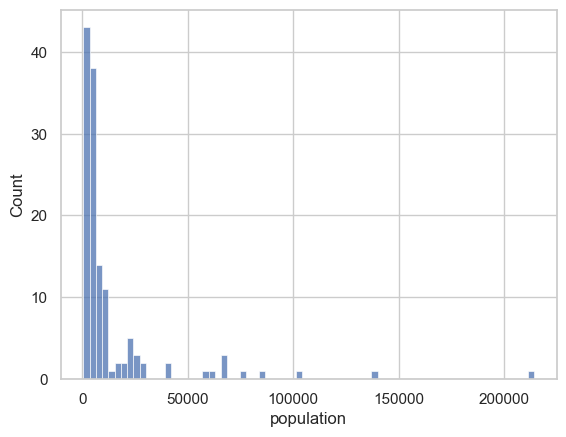

In [408]:
import seaborn as sns

sns.histplot(data=unique_towns, x="population")

<Axes: xlabel='population'>

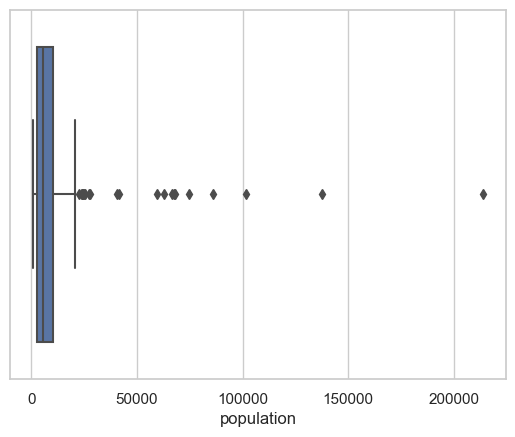

In [409]:
sns.boxplot(data=unique_towns, x="population")

In [410]:
unique_towns.population.quantile(.01)

821.76

In [475]:
unique_towns.sort_values(by='population').head(20)

,Year,#,Miles,Feet of Climb,Riders,Day,Town,name,centroid,lon,lat,population
382,1998,XXVI,488,"11,857","10,000",End,Sabula,Sabula,POINT (-90.17670 42.06673),-90.176698,42.066728,506
92,2014,XLII,428,"8,057","10,000",Sunday,Okoboji,Okoboji,POINT (-95.13900 43.39085),-95.138998,43.390853,768
314,1981,IX,490,"14,372","6,000",Friday,Keosauqua,Keosauqua,POINT (-91.96040 40.73455),-91.960398,40.734546,936
361,1977,V,400,"8,479","6,000",End,Lansing,Lansing,POINT (-91.22547 43.36066),-91.225469,43.360658,968
3,1976,IV,430,"13,737","4,000",Start,Sidney,Sidney,POINT (-95.64432 40.74625),-95.644317,40.746255,1070
73,1995,XXIII,493,"10,674","8,000",Sunday,Lake View,Lake View,POINT (-95.04108 42.30479),-95.041080,42.304788,1113
59,1981,IX,490,"14,372","6,000",Sunday,Mapleton,Mapleton,POINT (-95.79098 42.16727),-95.790978,42.167273,1165
313,1980,VIII,468,"11,912","6,000",Friday,Elkader,Elkader,POINT (-91.40291 42.85741),-91.402905,42.857407,1209
329,1996,XXIV,437,"9,869","8,000",Friday,Fayette,Fayette,POINT (-91.80337 42.84152),-91.803371,42.841520,1256
106,1977,V,400,"8,479","6,000",Monday,Laurens,Laurens,POINT (-94.84766 42.84762),-94.847656,42.847622,1264


<Axes: xlabel='Year', ylabel='population'>

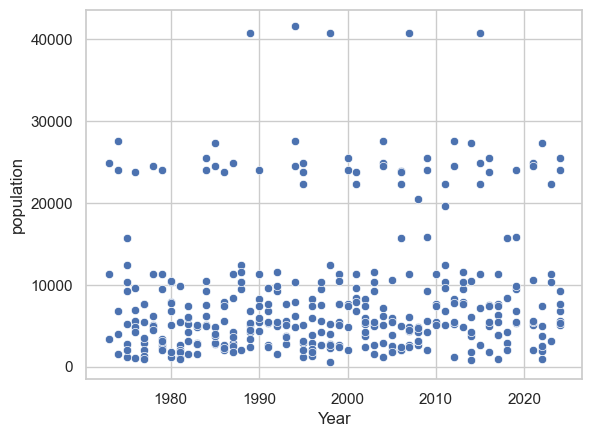

In [411]:
temp_df = merged_df[merged_df.population < 50000]
sns.scatterplot(data=temp_df, x='Year', y='population')

## Clustering Routes 

In [431]:
from sklearn.cluster import AgglomerativeClustering

In [469]:
# Reshape the dataframe to have one row per route_id and columns for lat/lon of each Day
reshaped_df = merged_df.pivot(index='route_id', columns='Day', values=['lat', 'lon'])

# Flatten the MultiIndex columns into single level with meaningful names
reshaped_df.columns = ['_'.join(col).strip() for col in reshaped_df.columns.values]
reshaped_df.reset_index(inplace=True)

# Prepare data for clustering by dropping rows with missing values
clustering_data = reshaped_df.drop('route_id', axis=1).dropna()

# Perform Agglomerative Clustering
agglo_cluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')
reshaped_df['Cluster'] = agglo_cluster.fit_predict(clustering_data)

reshaped_df.head(3)

,route_id,lat_End,lat_Friday,lat_Monday,lat_Start,lat_Sunday,lat_Thursday,lat_Tuesday,lat_Wednesday,lon_End,lon_Friday,lon_Monday,lon_Start,lon_Sunday,lon_Thursday,lon_Tuesday,lon_Wednesday,Cluster
0,1,42.499671,42.230765,41.677921,41.236861,41.395706,42.491917,41.690984,42.034276,-90.706423,-91.184012,-94.499030,-95.851575,-95.013834,-92.352215,-93.723400,-92.906722,0
1,2,40.620832,40.962173,42.304788,43.001759,42.750842,41.334024,42.053024,41.695933,-91.350478,-91.545212,-95.041080,-96.483206,-95.552836,-92.204442,-93.877105,-93.045029,4
2,3,41.419877,41.655880,41.649624,40.746255,41.014187,41.736002,42.016579,42.018646,-91.068557,-91.530680,-95.326876,-95.644317,-95.224830,-92.724418,-94.379266,-93.463541,0


In [470]:
reshaped_df

,route_id,lat_End,lat_Friday,lat_Monday,lat_Start,lat_Sunday,lat_Thursday,lat_Tuesday,lat_Wednesday,lon_End,lon_Friday,lon_Monday,lon_Start,lon_Sunday,lon_Thursday,lon_Tuesday,lon_Wednesday,Cluster
0,1,42.499671,42.230765,41.677921,41.236861,41.395706,42.491917,41.690984,42.034276,-90.706423,-91.184012,-94.499030,-95.851575,-95.013834,-92.352215,-93.723400,-92.906722,0
1,2,40.620832,40.962173,42.304788,43.001759,42.750842,41.334024,42.053024,41.695933,-91.350478,-91.545212,-95.041080,-96.483206,-95.552836,-92.204442,-93.877105,-93.045029,4
2,3,41.419877,41.655880,41.649624,40.746255,41.014187,41.736002,42.016579,42.018646,-91.068557,-91.530680,-95.326876,-95.644317,-95.224830,-92.724418,-94.379266,-93.463541,0
3,4,43.360658,43.301625,42.847622,42.026424,42.343793,43.055918,43.074317,43.134731,-91.225469,-91.784754,-94.847656,-96.090985,-95.473299,-92.315104,-94.230415,-93.373967,6
4,5,41.842899,42.058997,42.722900,42.494882,42.643014,41.923143,42.519620,42.163795,-90.242366,-90.664960,-94.223955,-96.389771,-95.197235,-91.424288,-93.266349,-92.026051,1
5,6,40.806894,41.177359,42.398130,43.427274,43.146458,41.006678,42.186549,41.963473,-91.124651,-91.187831,-94.628889,-96.166227,-95.153356,-91.966689,-93.586561,-92.573974,1
6,7,42.788119,42.857407,42.069448,41.044580,41.395706,42.725077,41.841994,42.462248,-91.105606,-91.402905,-94.864838,-95.740407,-95.013834,-92.470877,-94.099904,-93.816732,0
7,8,40.409673,40.734546,42.267637,41.559461,42.167273,40.729303,41.305827,40.740751,-91.403250,-91.960398,-94.730937,-95.902312,-95.790978,-92.871726,-94.459334,-93.754523,4
8,9,41.556945,41.770077,43.399780,42.826912,42.750842,42.462455,43.257099,43.064571,-90.605436,-91.128615,-94.834217,-96.557000,-95.552836,-91.902275,-93.636603,-92.674393,2
9,10,42.499671,42.485250,41.677921,42.026424,41.649624,42.363751,42.025621,42.731804,-90.706423,-91.455713,-94.499030,-96.090985,-95.326876,-92.773802,-93.621685,-93.729593,0


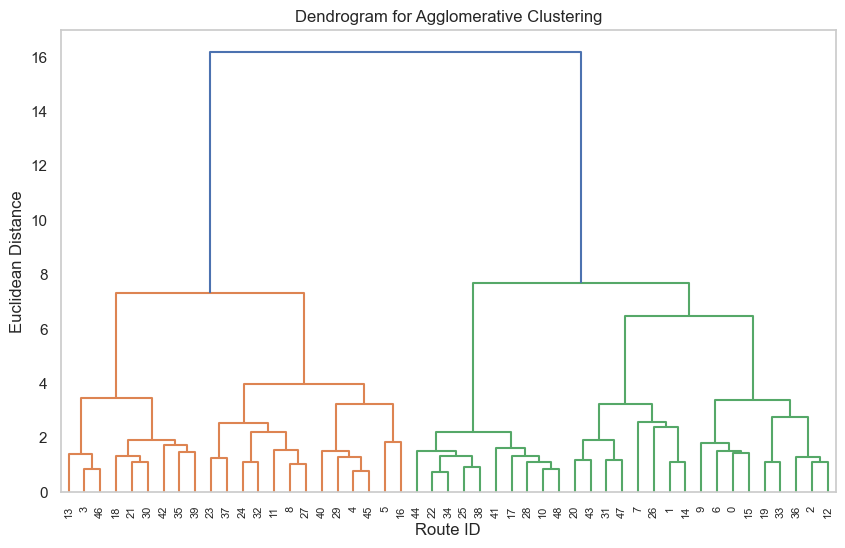

In [468]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Compute the linkage matrix
linkage_matrix = linkage(clustering_data, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix)
plt.title("Dendrogram for Agglomerative Clustering")
plt.xlabel("Route ID")
plt.ylabel("Euclidean Distance")
plt.grid(False)
plt.show()

In [444]:
clustered_df = merged_df.merge(reshaped_df[['route_id', 'Cluster']], on='route_id')

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

In [448]:
year_data

,Year,route_id,Day,Town,centroid,lon,lat,population
50,2024,50,Start,Glenwood,POINT (-95.74041 41.04458),-95.740407,41.044580,5073
101,2024,50,Sunday,Red Oak,POINT (-95.22483 41.01419),-95.224830,41.014187,5596
152,2024,50,Monday,Atlantic,POINT (-95.01383 41.39571),-95.013834,41.395706,6792
203,2024,50,Tuesday,Winterset,POINT (-94.01883 41.33822),-94.018832,41.338224,5353
254,2024,50,Wednesday,Knoxville,POINT (-93.10273 41.31892),-93.102727,41.318921,7595
305,2024,50,Thursday,Ottumwa,POINT (-92.41864 41.01942),-92.418637,41.019416,25529
356,2024,50,Friday,Mount Pleasant,POINT (-91.54521 40.96217),-91.545212,40.962173,9274
407,2024,50,End,Burlington,POINT (-91.12465 40.80689),-91.124651,40.806894,23982


3

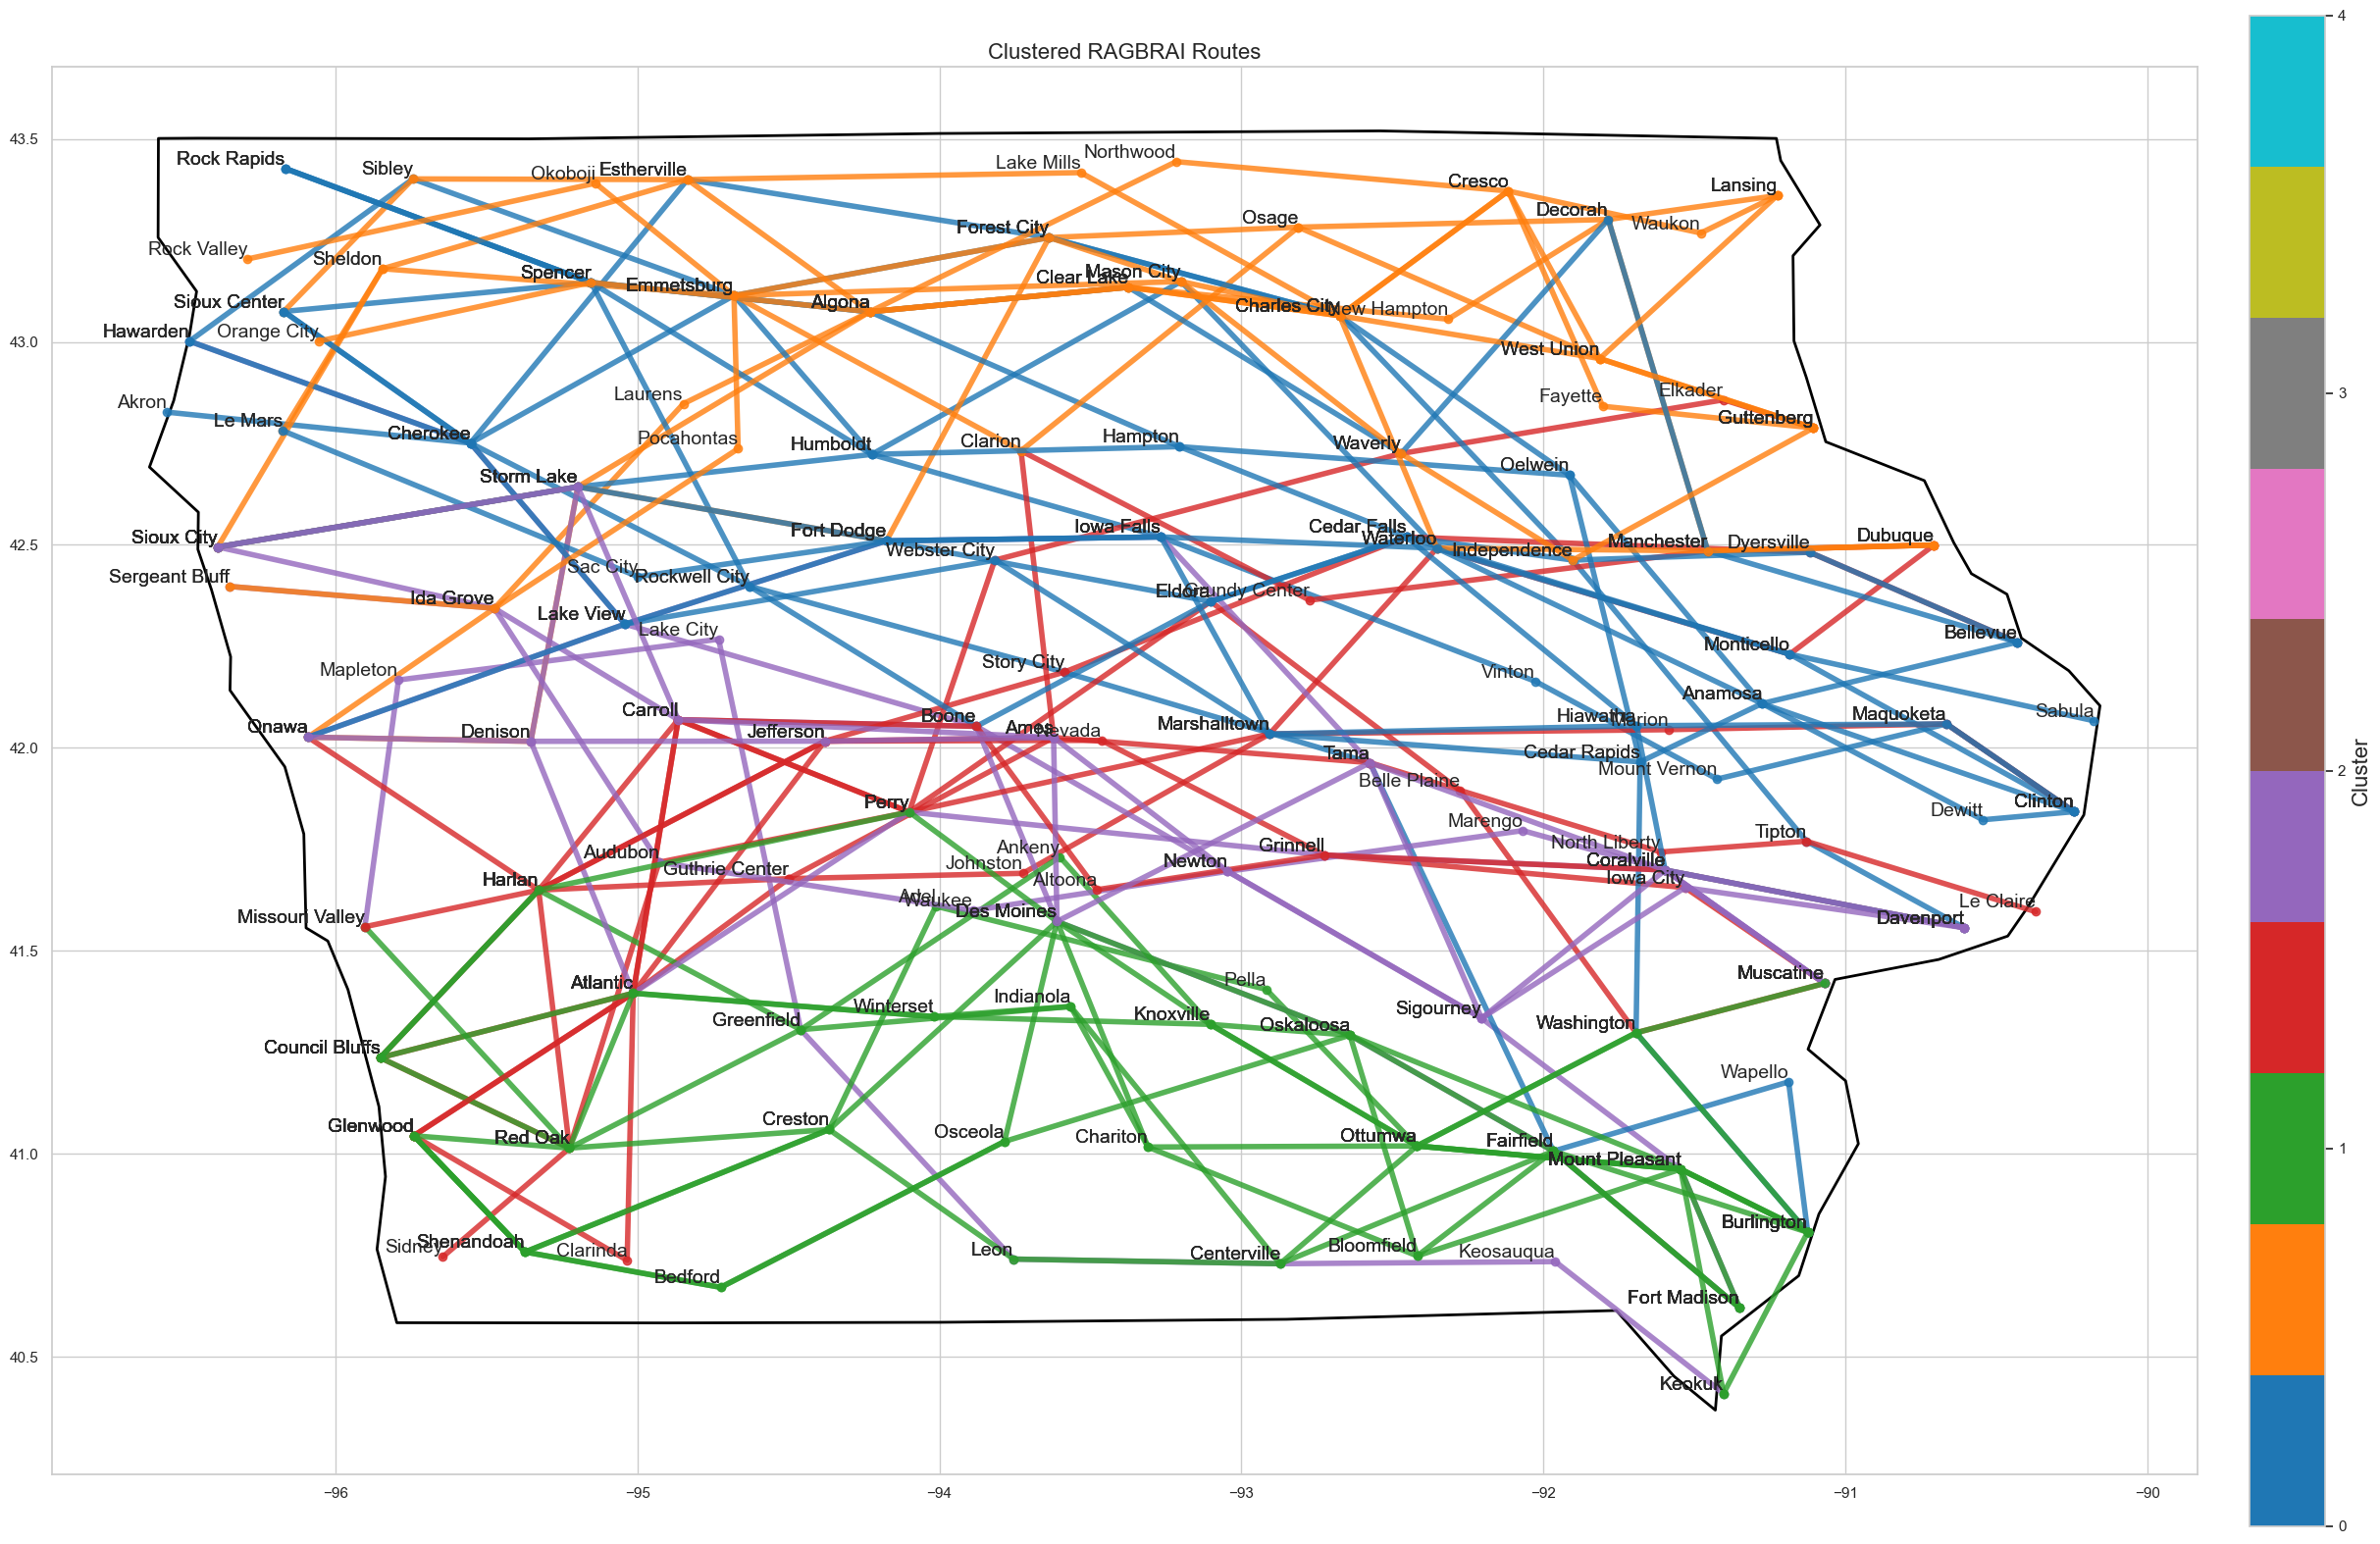

In [472]:
import matplotlib as mpl
# Plot the Iowa map
fig, ax = plt.subplots(figsize=(34, 20))
iowa_map.plot(ax=ax, color='none', edgecolor='black', linewidth=2, label='Iowa State Border')
# cmap = sns.color_palette("tab10")
cmap = sns.color_palette("tab10", as_cmap=True)
norm = mpl.colors.Normalize(vmin=clustered_df['Cluster'].min(), vmax=clustered_df['Cluster'].max())
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # ScalarMappable requires an array, even if not used for mapping


for year in years:
    year_data = clustered_df[clustered_df['Year'] == year]
    # Sort by Day to maintain the route order
    year_data['Day'] = pd.Categorical(year_data['Day'], categories=route_columns, ordered=True)
    year_data = year_data.sort_values('Day')
    cluster = year_data['Cluster'].values[0]

    # Plot the route
    ax.plot(year_data['lon'], year_data['lat'], marker='o', label=f"Year {year}", color=cmap(cluster), alpha=.8, linewidth=4)
    
    # Annotate the towns
    for x, y, label in zip(year_data['lon'], year_data['lat'], year_data['Town'].str.title()):
        ax.text(x, y, label, fontsize=14, ha='right', va='bottom')

plt.title("Clustered RAGBRAI Routes", fontsize=16)
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Cluster', fontsize=16)
cbar.set_ticks(range(clustered_df['Cluster'].min(), clustered_df['Cluster'].max() + 1))
cbar.set_ticklabels(range(clustered_df['Cluster'].min(), clustered_df['Cluster'].max() + 1))
plt.show()
